# Setup an Hadoop Cluster


Author: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>
Date: July 26, 2020

`Notebook status:` in progress

`Audience:` Written with Python users in mind. I will ocasionally add some notes for R users.


`Citations:`

1. CloudLab: https://www.cloudlab.us

2. Hadoop cluster setup: https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html

3. Spark cluster setup: http://spark.apache.org/docs/latest/spark-standalone.html

4. Awesome book on Hadoop/HDFS/Spark: http://grut-computing.com/HadoopBook.pdf

5. More notes on Hadoop/Spark cluster setup: [link1](http://pages.cs.wisc.edu/~akella/CS838/F15/assignment1.html); [link2](http://pages.cs.wisc.edu/~akella/CS838/F15/assignment2.html)
   
6. Secure file transfer: https://linuxize.com/post/how-to-use-scp-command-to-securely-transfer-files/

7. PySpark for Jupyter notebooks: [link1](https://opensource.com/article/18/11/pyspark-jupyter-notebook); [link2](https://mortada.net/3-easy-steps-to-set-up-pyspark.html)

8. Hadoop commands reference: https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/CommandsManual.html

9. Bash (terminal) commands: https://devhints.io/bash


``For Python users``

[ADD Here]


``For R users``

How to add an R kernel: conda install -c r r-irkernel

How to add packages: https://docs.anaconda.com/anaconda/packages/r-language-pkg-docs/#t-packages

How to fix errors: R libreadline error: [link1](https://askubuntu.com/questions/1168787/libreadline-so-6-issue-in-ubuntu-18-04); [link2](https://stackoverflow.com/questions/23993377/red-language-console-error-libreadline-so-6-cannot-open-shared-object-file)

In [2]:
from IPython.display import Image

We will start by creating an experiment and topology in CloudLab (Note: you need to create an account).

https://www.cloudlab.us

---
#### Step 1: Create experiment and topology
---

``Check Resource Availability on CloudLab``

Experiments -> Resource Availability (copy the ID of a CloudLab server you want to request).

``Reserve nodes and create topology``

Experiments -> Create Experiment Profile -> [ADD Name] -> Create Topology -> [DRAG Bare Metal PC (e.g., x2 if 2 nodes)] -> [LINK nodes] -> [CLICK on each node (select hardware type] -> Accept -> Create -> Instantiate -> Next -> Finish.

Experiments -> My Experiments -> [CLICK your experiment name] -> List View -> [COPY IP addresses for each node (you will use these to login remotely to each node].

To extend experiment: Experiments -> My Experiments -> [CLICK your experiment name] -> List View -> [COPY IP addresses for each node] -> Extend.

``Short description of our Experiment``

I reserved 4 nodes, each with about 220GB of RAM. The topology I created in CloudLab shows that these nodes are named 'node-0', 'node-1', 'node-2', node-3'.

We will define 'node-0' as our Master node. And we will define 'node-0', 'node-1', 'node-2', node-3' as our Worker nodes. Note that 'node-0' is both a Master and a Worker node.

---
#### Step 2: Generate a SSH key on your local machine
---

``Definitions:``
 - Local machine == the machine you will use to connect to the cluster of nodes.

 - A SSH key is used for automating logins, single sign-on, and for authenticating hosts.

``Comments:``

When you run the *ssh-keygen -t rsa* command:
  - Enter file in which to save the key: [if you leave it blank it will be saved in the id_rsa.pub file].
  - Enter passphrase: [leave it empty].
  - Enter same passphrase again: [leave it empty].

When you run *less id_rsa.pub* command:
  - copy the key and add it to CloudLab ([SELECT your user name] -> Manage SSH Keys.


In [ ]:
!ssh-keygen -t rsa
!ls -la
!less id_rsa.pub

---
#### Step 3: Connect to each node from the command line
---

You will open a Shell tab for each node and type:

In [ ]:
!ssh cilin@c220g5-111028.wisc.cloudlab.us #change this with the IP address of each node (see Step1 for location of IP address)

---
#### Step 4: Establish passwordless SSH connection between nodes
---    

First, check to see if you can connect from one node to another.

Run the code below in the Shell corresponding to the main node (node-0). 

In [ ]:
!ssh node-1 #note: this command is run on node-0. It tries to connect to node-1

If permission is denied (very likely), create a public key on the main node (node-0) and propagate the key to the other nodes. 

In [ ]:
!ssh-keygen -t rsa -f node1 #note: this command is run on node-0
!ls -la
!less id_rsa.pub

To propagate the node-0 key to the other nodes, add it to CloudLab ([SELECT your user name] -> Manage SSH Keys. See Step 2 comments related to the output of the code above.

---
#### Step 5: Mount more hard drive on each node
---

At instantiation, the hard drive space allocated (mounted) for use on each Linux node is usually very small. So we need to change this because our data needs to sit there.

Definitions:
 - Hard drive naming convention in Linux: what you need to know is that there is no C drive or E drive in Linux. You will see something like /dev/sda, /dev/sdb, /dev/sdc, … etc. instead (these are called hard disk paritions in Linux). The dev is short for device. The sd was short for Small Computer System Interface (SCSI) mass-storage driver. Below is an example figure.


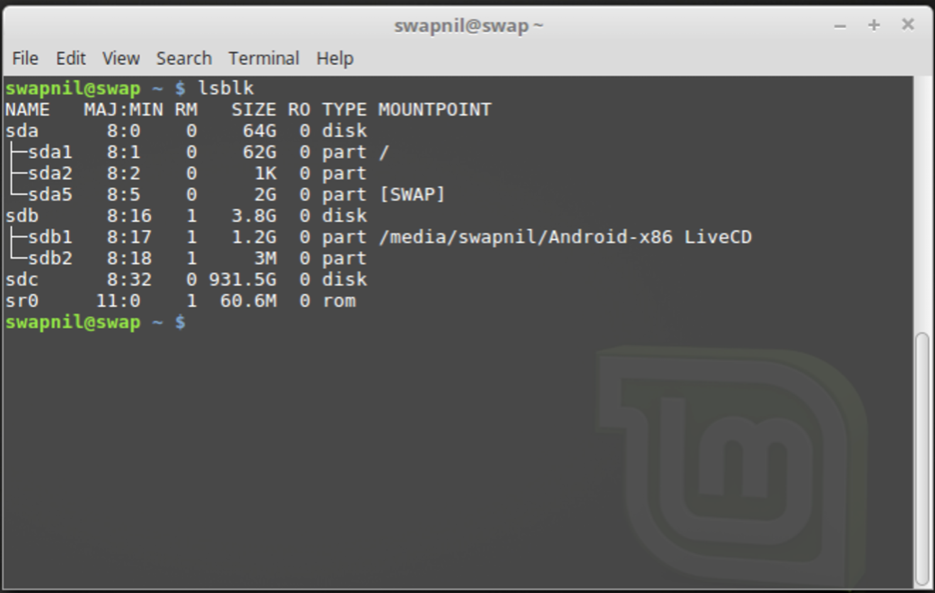

In [3]:
Image(filename='Linux_hard_drive.png', width=500)

Check how much disk space is mounted by default: this information is available under */dev/sda, /dev/sdb, /dev/sdc*. 

In [ ]:
!df -h #command for a single node
!for i in {5:8}: do ssh node-${i} "df -h" #command to run on all nodes

Now check what other partitions are available.

In [ ]:
!lsblk ##command for a single node
!for i in {5:8}: do ssh node-${i} "lsblk" #command to run on all nodes

It seems that we have >1 TB of (unmounted) disk space in /dev/sdb, so let's mount this space on a directory called *storage*. We will do this for each node.

``Step 5.1.`` Format dev/sdb

In [ ]:
!sudo mkfs.ext4/dev/sdb #command for a single node
!for i in {5..8}; do ssh node-${i} "sudo mkfs.ext4/dev/sdb"; done #command to run on all nodes

``Step 5.2.`` Create the directory where you will mount this disk space

In [ ]:
!mkdir storage # command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir /users/cilin/storage"; done #command to run on all nodes

``Step 5.3.`` Mount dev/sdb to users/cilin/storage

In [ ]:
!sudo mount -t ext4 /dev/sdb /users/cilin/storage #command for a single node
!for i in {5..8}; do ssh node-${i} "sudo mount -t ext4 /dev/sdb /users/cilin/storage"; done #command to run on all nodes

!df -h #to make sure it worked (runs on a single node)

``Step 5.4.`` Change the permissions to users/cilin/storage to be accessed by anyone

In [ ]:
!sudo chmod -R 777 /users/cilin/storage #command for a single nodes
!for i in {5..8}; do ssh node-${i} "sudo chmod -R 777 /users/cilin/storage" #command to run on all nodes

---
#### Step 6: Install software on each node
---

We want to install Java, Hadoop, and Anaconda (contains both Python and R) on each node. To keep organized, let's create a directory called *software* to add all programs but Java.

In [ ]:
!mkdir /users/cilin/software #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir /users/cilin/software"; done

#### <span style="color:red">Install Java</span>

``Step 6.1.-Java`` Check to see what Java versions are available in Ubuntu's repo

In [ ]:
!sudo apt-cache search openjdk  #you can check this command only on one node

It seems that two Java versions are available: jdk8 and jdk11. Let's install the latest version, jdk11.

``Step 6.2.-Java`` Install jdk11

First, we need to refresh all the repositories in each node.

In [ ]:
!sudo apt-get update #command for a single node
!for i in {5..8}; do ssh node-${i} "sudo apt-get update"; done #command to run on all node

Second, install jdk11 on each node.

In [ ]:
!sudo apt-get install openjdk-11-jdk #command for a single machine
!for i in {5..8}; do ssh node-${i} "sudo apt-get install openjdk-11-jdk"; done #command to run on all machines

#### <span style="color:red">Install Hadoop</span>

We want to install the latest version of Hadoop (3.3.0 at the time of writing this notebook) from here: https://hadoop.apache.org/releases.html

Copy the link of the binary file: https://www.apache.org/dyn/closer.cgi/hadoop/common/hadoop-3.3.0/hadoop-3.3.0.tar.gz

Then run the following in the command line (remember to save Hadoop in the *software* folder):

``Step 6.1.-Hadoop`` Download the binary .tar.gz file from their website

In [ ]:
!wget https://www.apache.org/dyn/closer.cgi/hadoop/common/hadoop-3.3.0/hadoop-3.3.0.tar.gz #command for a single node
!for i in {5..8}; do ssh node-${i} "cd~/software; wget https://www.apache.org/dyn/closer.cgi/hadoop/common/hadoop-3.3.0/hadoop-3.3.0.tar.gz; ls"; done #command to run on all nodes    

``Step 6.2.-Hadoop`` Unzip the binary .tar.gz file

In [ ]:
!cd ~/sfotware
!tar -xzvf hadoop-3.3.0.tar.gz #command for a single node
!for i in {5..8}; do ssh node-${i} "cd~/software; tar -xzvf hadoop-3.3.0.tar.gz; ls"; done #command to run on all nodes    

``Step 6.3.-Hadoop`` Configure HDFS on each node

HDFS is the equivalent of the file system in your local machine, the only difference is that it runs on multiple machines.

#### <span style="color:green"> configure core-site.xml and hdfs-site.xml files</span>

On your local machine, configure the files **core-site.xml** and **hdfs-site.xml** (you can find them in hdfs_config_files). Note that you can also transfer these files to the Master node-5, edit with vim, and then transfer the edited files to all the other nodes. These files will be copied in a directory called *config*.

I also provide the core-site[original].xml and hdfs-site[original].xml files for a better understanding on where your edits(configurations) should go.

Useful vim commands (if you want to edit in the node):
 - **i** (stands for insert so you can edit)
 - **esc** and then **:wq!** to save and exit

(A) Create *config* directory

In [ ]:
!mkdir /users/cilin/config #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir /users/cilin/config"; done #command to run on all nodes

(B) Assuming you have configured the **core-site.xml** and **hdfs-site.xml** files according with the instructions presented there, let's copy them on each node from our local machine.

In [ ]:
# copy on Master (node-5) from Local Machine
!scp -r ~/Research/hprm/CloudLab/HDFS_config_files* cilin@128.105.144.198:/users/cilin/config 

# copy on all the other nodes from Master
!for i in {6:8}; do scp -r* node-${i}:users/cilin/config; done

(C) Finally, we need to create the directories listed in the **core-site.xml** and **hdfs-site.xml** files on each node.

These directories are:
 - /users/cilin/storage/data/local/tmp
 - /users/cilin/storage/hdfs/hdfs_nn_dir
 - /users/cilin/storage/hdfs/hdfs_dn_dirs

In [ ]:
!mkdir -p /users/cilin/storage/data/local/tmp #command for a single node
for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/data/local/tmp"; done #command to run on all nodes

In [ ]:
!mkdir -p /users/cilin/storage/hdfs/hdfs_nn_dir #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/hdfs/hdfs_nn_dir"; done #command to run on all nodes

In [ ]:
!mkdir -p /users/cilin/storage/hdfs/hdfs_dn_dirs #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/hdfs/hdfs_dn_dirs"; done #command to run on all nodes

#### <span style="color:green"> configure run.sh file for Hadoop</span>

We will follow the same steps as above to ocnfigure the *run.sh* file (you can find it in run_files). We will copy the run.sh file on the *home directory* of each machine.

You can see that the *run.ch* files contains configurations for both Hadoop and Spark. I recommend you edit the configurations for Spark too because we will need them later on.

I also provide the run[original].sh file for a better understanding on where your edits(configurations) should go.

(A) Assuming you have configured the **run.sh** file according with the instructions presented there, let's copy it on each node from our local machine.

In [8]:
# copy on Master (node-0) from Local Machine
!scp -r ~/Research/hprm/CloudLab/Run_files/run.sh cilin@128.105.144.198:/users/cilin/ #the IP address here is Master node-0's IP.

# copy on all the other nodes from Master
!for i in {6:8}; do scp -r run.sh node-${i}:users/cilin/; done

(B) We need to create the Hadoop related directories listed in the **run.sh** file on each node.

These directories are:
 - /users/cilin/storage/logs/hadoop


In [ ]:
!mkdir -p /users/cilin/storage/logs/hadoop #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/logs/hadoop"; done #command to run on all nodes

(C) Create a file called *instances* that lists the IP eddress (on a separate line) of each node.  This file should be created in the home directory.

In [ ]:
!vim instances #after this you edit the doc as indicated above

(D) In the run.sh file, you can see a command *pdsh* (PDSH is a very smart little tool that enables you to issue the same command on the nodes specified in the file *instances*). So we need to install *pdsh* on every node.

In [ ]:
!sudo apt-get install pdsh #command for a single node
!for i in {5..8}; do ssh node-${i} "sudo apt-get install pdsh"; done #command to run on all nodes

(E) We need to make the functions defined in run.ch available in the terminal of each node.

In [ ]:
!source ~/run.sh #command for a single node
!for i in {5..8}; do ssh node-${i} "source ~/run.sh"; done #command to run on all nodes

(F) Finally, we need to add the run.ch file in the .bashrc file and then source the .bshrc file

In [ ]:
# add run.ch to .bashrc
!vim .bashrc #this command has to be run on each node; commands once in edit mode: i, make edits (source ~/run.sh), esc, :wq!

In [ ]:
# source .bshrc (or connect again to all nodes)
!source ~/.bshrc #command for a single node
!for i in {5..8}; do ssh node-${i} "source ~/.bashrc"; done #command to run on all nodes

#### <span style="color:green"> format the HDFS system file</span>

This has to be done only on the Master (node-0). In HDFS terminology, the Master node is called the NameNode.

In [ ]:
!hadoop namenode -format

#### <span style="color:green"> connect from Master node to Worker nodes</span>

You will connect using the IPs from the *instances* file. The idea here is to allow HDFS to connect automatically to each worker node without confirmation. This confirmation is required only once, so we want to do it in this setup stage. 

Important: don't forget to connect from Master node to Master node as well!

In [ ]:
!ssh 128.105.144.182 #this connects to node-1 (the IP address here belongs to node-1)

#### <span style="color:green"> start HDFS </span>

In [11]:
!start_hdfs #this function is available in the run.ch file; run it only on the Master node-0

#### <span style="color:green"> check that DataNode and NameNode exist</span>

Note: DataNode and NameNode ==  Master node and Worker node.

In [ ]:
!jps #check this on each node (note that Worker nodes only have a NameNode)

#### <span style="color:green"> access HDFS using GUI</span>

The http:// address is the IP of the Master node-0 followed by the port 50070 (this is the port we defined in hdfs_site.xml file).

http://128.105.144.198:50070/dfshealth.html#tab-overview

#### <span style="color:green"> copy files to HDFS</span>

(A) first, copy the data from Local Machine to the Master (node-0).

In *storage*, let's create a folder named *data_to_copy_in_hdfs*.

In [ ]:
# this command is run from Master (Node-0)
!mkdir ~/storage/data_to_copy_in_hdfs

# this command is run form local machine
!scp -r ~/Research/hprm/data/infogroup/* cilin@128.105.144.198:/users/cilin/storage/data_to_copy_in_hdfs

(B) second, copy the data from the Master (node-0) to HDFS.

Let's create a folder named 'hdfs_data' in Hadoop.

In [ ]:
# these commands are run from Master (Node-0)
!hadoop dfs -mkdir /hdfs_data #/ indicates the home directory 

!hadoop fs  -copyFromLocal /users/cilin/storage/data_to_copy_in_hdfs/ /hdfs_data

(C) check to see if the files are in HDFS

#### <span style="color:red">Install Spark</span>

We want to install the latest version of Spark(3.0.0 at the time of writing this notebook) from here: https://spark.apache.org/downloads.html

Copy the link of the binary file: https://www.apache.org/dyn/closer.lua/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

Then run the following in the command line (remember to save Spark in the *software* folder):

``Step 6.1.-Spark`` Download the binary .tgz file from their website

In [ ]:
!wget https://www.apache.org/dyn/closer.lua/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz #command for a single node
!for i in {5..8}; do ssh node-${i} "cd~/software; wget https://www.apache.org/dyn/closer.lua/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz; ls"; done #command to run on all nodes    

``Step 6.2.-Spark`` Unzip the binary .tgz file

In [ ]:
!cd ~/sfotware
!tar -xzvf hadoop-3.3.0.tar.gz #command for a single node
!for i in {5..8}; do ssh node-${i} "cd~/software; tar -xzvf hadoop-3.3.0.tar.gz; ls"; done #command to run on all nodes    

#### <span style="color:green"> configure run.sh file for Spark commands</span>

(A) We need to create the Spark related directories listed in the **run.sh** file on each node.

These directories are:
 - /users/cilin/storage/data/spark/rdds_shuffle
 - /users/cilin/storage/logs/spark
 - /users/cilin/storage/logs/apps_spark

In [ ]:
!mkdir -p /users/cilin/storage/data/spark/rdds_shuffle #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/data/spark/rdds_shuffle"; done #command to run on all nodes

In [ ]:
!mkdir -p /users/cilin/storage/logs/spark #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/logs/spark"; done #command to run on all nodes

In [ ]:
!mkdir -p /users/cilin/storage/logs/apps_spark #command for a single node
!for i in {5..8}; do ssh node-${i} "mkdir -p /users/cilin/storage/logs/apps_spark"; done #command to run on all nodes

#### <span style="color:green"> start Spark</span>

In [ ]:
!start_spark #this function is available in the run.ch file; run it only on the Master node-0

#### <span style="color:green"> check that Master node and Worker node exist</span>

In [ ]:
!jps #check this on each node (note that Worker nodes only have a Worker)

#### <span style="color:green"> access Spark using GUI</span>

The http:// address is the IP of the Master node followed by the port 8080 (this is the port defined on Spark's website).

http://128.105.144.198:8080

Citation: http://spark.apache.org/docs/latest/spark-standalone.html

#### <span style="color:red">Install Anaconda</span>

We want to install the latest version of Anaconda from here: https://www.anaconda.com/products/individual#linux

Copy the link of the Linux file: https://repo.anaconda.com/archive/Anaconda3-2020.07-Linux-x86_64.sh

Then run the following in the command line (remember to save Anaconda in the *software* folder):

``Step 6.1.-Anaconda`` Download the linux .sh file from their website

In [ ]:
!wget https://repo.anaconda.com/archive/Anaconda3-2020.07-Linux-x86_64.sh #command for a single node
!for i in {5..8}; do ssh node-${i} "cd~/software; wget https://repo.anaconda.com/archive/Anaconda3-2020.07-Linux-x86_64.sh; ls"; done #command to run on all nodes    

``Step 6.2.-Anaconda`` Enter the following to install Anaconda for Python 3.7:

In [ ]:
!bash ~/Software/Anaconda3-2020.02-Linux-x86_64.sh

``Step 6.3.-Anaconda`` Source .bashrc for installation to take effect

In [ ]:
!source ~/.bshrc #command for a single node
!for i in {5..8}; do ssh node-${i} "source ~/.bashrc"; done #command to run on all nodes

``Step 6.4.-Anaconda`` Activate base environment or not

check step 11 here: https://docs.anaconda.com/anaconda/install/linux/

``Step 6.4.-Anaconda`` Install PySpark

In [6]:
!conda install pyspark

``Step 6.5.-Anaconda`` Launch Jupyter Notebook/Lab

On node-0's terminal type:

In [ ]:
!jupyter lab